# Image classification with a small CNN (cats vs dogs)

Adapted from Chapter 8 of François Chollet's *Deep Learning with Python*.

This version **does not rely on Kaggle**. Instead, it uses a public Google-hosted
mirror of the filtered cats vs dogs dataset:
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

It also creates a proper **train / validation / test** split by moving a subset of
images into a new `test/` directory:

- 200 cats + 200 dogs from `train/`
- 100 cats + 100 dogs from `validation/`

You can run this notebook directly in Colab. A GPU is recommended but not required.

In [1]:
import os
import pathlib
import zipfile
import random
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


## Download and extract the cats vs dogs dataset (Google mirror)

We download the zip file to Keras' cache directory and then **explicitly extract** it.
After extraction, we robustly locate the `cats_and_dogs_filtered` directory.

In [2]:
import os
import zipfile
from pathlib import Path

# Use the file you uploaded via the Colab file browser
local_zip = "cats_and_dogs_filtered_zip.zip"  # adjust if ls shows a different name
print("Zip path:", local_zip)

# Explicitly extract to /content
with zipfile.ZipFile(local_zip, "r") as zf:
    zf.extractall("/content")

# UNCOMMENT THESE LINES - they find the extracted directory
candidates = [p for p in Path("/content").glob("cats_and_dogs_filtered*") if p.is_dir()]
if not candidates:
    raise RuntimeError("Could not find extracted cats_and_dogs_filtered directory under /content")

base_dir = candidates[0]
print("Using base_dir:", base_dir)

train_dir = base_dir / "train"
validation_dir = base_dir / "validation"

train_cats_dir = train_dir / "cats"
train_dogs_dir = train_dir / "dogs"
validation_cats_dir = validation_dir / "cats"
validation_dogs_dir = validation_dir / "dogs"

# Count images before any splitting
num_train_cats = len(list(train_cats_dir.glob("*.jpg")))
num_train_dogs = len(list(train_dogs_dir.glob("*.jpg")))
num_val_cats = len(list(validation_cats_dir.glob("*.jpg")))
num_val_dogs = len(list(validation_dogs_dir.glob("*.jpg")))

print("BEFORE SPLIT:")
print("Training cats:", num_train_cats)
print("Training dogs:", num_train_dogs)
print("Validation cats:", num_val_cats)
print("Validation dogs:", num_val_dogs)

# Optional quick directory peek if counts are 0
if (
    num_train_cats == 0
    and num_train_dogs == 0
    and num_val_cats == 0
    and num_val_dogs == 0
):
    print("\nFirst 40 paths under base_dir for debugging:")
    for p in list(base_dir.rglob("*"))[:40]:
        print("  ", p)



Zip path: cats_and_dogs_filtered_zip.zip
Using base_dir: /content/cats_and_dogs_filtered
BEFORE SPLIT:
Training cats: 1000
Training dogs: 1000
Validation cats: 500
Validation dogs: 500


## Create a proper test split

We create a new `test/` directory and **move** images into it so the test data is
never seen during training:

- 200 cats + 200 dogs from `train/`
- 100 cats + 100 dogs from `validation/`

In [3]:
# Reproducibility
random.seed(1337)

# Create test directories
test_dir = base_dir / "test"
test_cats_dir = test_dir / "cats"
test_dogs_dir = test_dir / "dogs"

for d in [test_dir, test_cats_dir, test_dogs_dir]:
    d.mkdir(parents=True, exist_ok=True)

def move_subset(src_dir, dst_dir, n):
    files = list(src_dir.glob("*.jpg"))
    if len(files) < n:
        print(f"Warning: requested {n} files from {src_dir}, but only {len(files)} available. Using all.")
        n = len(files)
    selected = random.sample(files, n)
    for p in selected:
        shutil.move(str(p), dst_dir / p.name)

# 200 from train (cats & dogs)
move_subset(train_cats_dir, test_cats_dir, 200)
move_subset(train_dogs_dir, test_dogs_dir, 200)

# 100 from validation (cats & dogs)
move_subset(validation_cats_dir, test_cats_dir, 100)
move_subset(validation_dogs_dir, test_dogs_dir, 100)

# Recount after the move
num_train_cats = len(list(train_cats_dir.glob("*.jpg")))
num_train_dogs = len(list(train_dogs_dir.glob("*.jpg")))
num_val_cats = len(list(validation_cats_dir.glob("*.jpg")))
num_val_dogs = len(list(validation_dogs_dir.glob("*.jpg")))
num_test_cats = len(list(test_cats_dir.glob("*.jpg")))
num_test_dogs = len(list(test_dogs_dir.glob("*.jpg")))

print("AFTER SPLIT:")
print("Training cats:", num_train_cats)
print("Training dogs:", num_train_dogs)
print("Validation cats:", num_val_cats)
print("Validation dogs:", num_val_dogs)
print("Test cats:", num_test_cats)
print("Test dogs:", num_test_dogs)


AFTER SPLIT:
Training cats: 800
Training dogs: 800
Validation cats: 400
Validation dogs: 400
Test cats: 300
Test dogs: 300


## Visualize a few training images

Quick sanity check: we sample a few images from both classes.

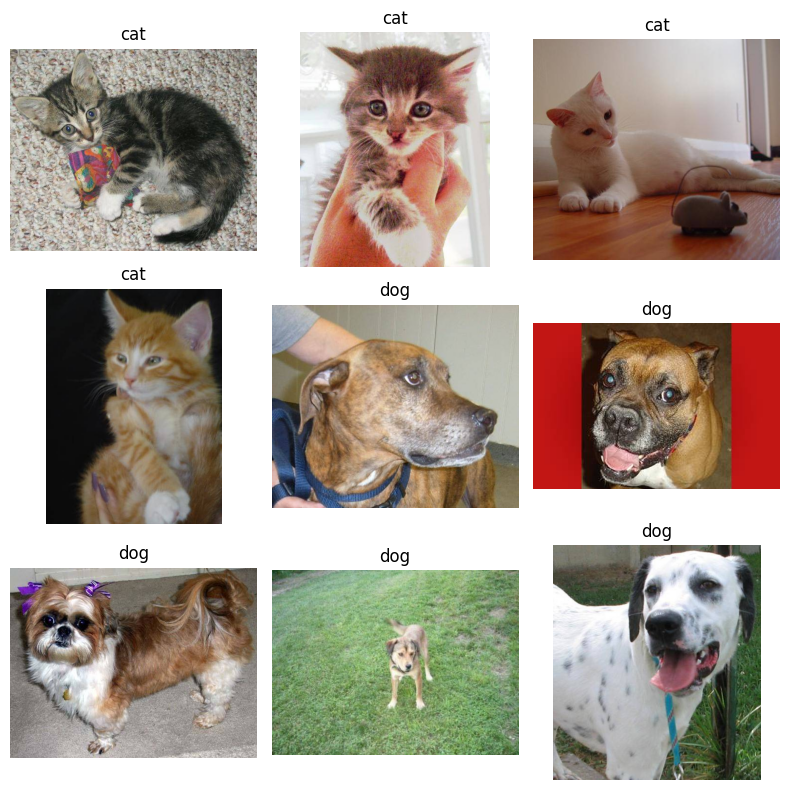

In [4]:
import matplotlib.image as mpimg
import numpy as np

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 8))
axes = axes.flatten()

cat_images = list(train_cats_dir.glob("*.jpg"))[: nrows * ncols // 2]
dog_images = list(train_dogs_dir.glob("*.jpg"))[: nrows * ncols - len(cat_images)]
all_images = cat_images + dog_images

for ax, img_path in zip(axes, all_images):
    img = mpimg.imread(str(img_path))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("cat" if "cat" in img_path.name else "dog")

plt.tight_layout()
plt.show()


## Set up data generators (train / validation / test)

We use `ImageDataGenerator` to rescale pixel values and stream images from disk.

In [ ]:
from PIL import Image

# Pick any image from your dataset
sample_image_path = list(train_cats_dir.glob("*.jpg"))[1]
img = Image.open(sample_image_path)
print(f"Original size: {img.size}")  # Returns (width, height)

In [5]:
img_height = 224
img_width = 224
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False,  # important if you later want to inspect predictions in order
)


Found 1600 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


## Build a small convolutional neural network (Functional API)

This is the same architecture as a simple `Sequential` convnet, but written in
Keras' **Functional API** style, which makes the computation graph explicit.

In [6]:
inputs = keras.Input(shape=(img_height, img_width, 3))

x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), activation="relu")(x)  # NEW: increased to 256 filters
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), activation="relu")(x)  # NEW: another 256 layer
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)  # NEW: dropout to prevent overfitting
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)  # NEW: another dropout
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,256,321 (16.24 MB)

 Trainable params: 4,256,321 (16.24 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

We use binary crossentropy loss because this is a two-class problem.

In [7]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=["accuracy"],
)

epochs = 50

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.5010 - loss: 0.6955 - val_accuracy: 0.5000 - val_loss: 0.6903
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5219 - loss: 0.6917 - val_accuracy: 0.5275 - val_loss: 0.6829
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5664 - loss: 0.6791 - val_accuracy: 0.6037 - val_loss: 0.6653
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5895 - loss: 0.6693 - val_accuracy: 0.5913 - val_loss: 0.6636
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5837 - loss: 0.6503 - val_accuracy: 0.6125 - val_loss: 0.6529
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6145 - loss: 0.6440 - val_accuracy: 0.6350 - val_loss: 0.6282
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6324 - loss: 0.6395 - val_accuracy: 0.6475 - val_loss: 0.6192
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.6711 - loss: 0.6106 - val_accuracy: 0.67

## Plot training and validation curves

This helps you diagnose overfitting and underfitting.

NameError: name 'label' is not defined

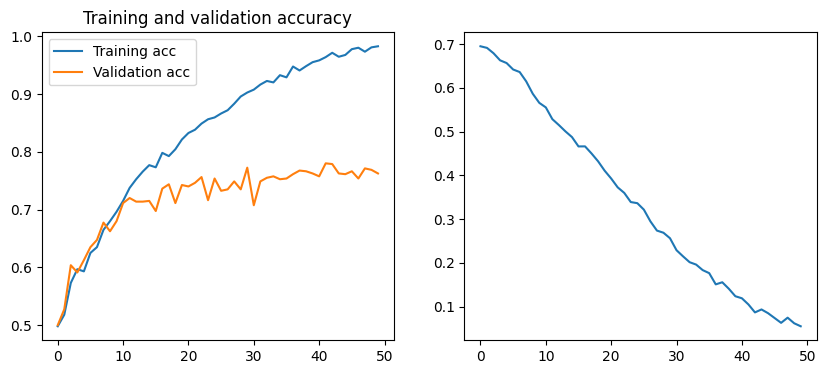

In [8]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training acc")
plt.plot(epochs_range, val_acc, label="Validation acc")
plt.legend()
plt.title("Training and validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label("Validation loss"))
plt.legend()
plt.title("Training and validation loss")

plt.tight_layout()
plt.show()


## Evaluate on the held-out test set

Finally, we evaluate the trained model on the `test/` directory that was never
used during training.

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8166 - loss: 0.7829
Test accuracy: 0.7916666865348816
Test loss: 0.8963243365287781


In [10]:
import keras_hub

# Load pretrained Xception (frozen - not trainable)
conv_base = keras_hub.models.Backbone.from_preset(
    "xception_41_imagenet",
    trainable=False,
)

# Build your model using the pretrained base
inputs = keras.Input(shape=(224, 224, 3))  # Xception expects 224x224

# Pass through pretrained convolutional base
x = conv_base(inputs)

# Add your own classifier on top
x = layers.GlobalAveragePooling2D()(x)  # Alternative to Flatten
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Compile and train as before
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
import keras_hub

# Load pretrained Xception
conv_base = keras_hub.models.Backbone.from_preset(
    "xception_41_imagenet",
    trainable=False,
)

# Build new model
inputs = keras.Input(shape=(224, 224, 3))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_transfer = keras.Model(inputs=inputs, outputs=outputs)

# Compile it
model_transfer.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_transfer.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception_backbone               │ (None, 7, 7, 2048)     │    20,861,480 │
│ (XceptionBackbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,911,081 (83.58 MB)

 Trainable params: 21,856,553 (83.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [12]:
history_transfer = model_transfer.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 295ms/step - accuracy: 0.8706 - loss: 0.2971 - val_accuracy: 0.7350 - val_loss: 15.2501
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9200 - loss: 0.2974 - val_accuracy: 0.8363 - val_loss: 1.3851
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.9490 - loss: 0.1431 - val_accuracy: 0.7262 - val_loss: 3.2433
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 245ms/step - accuracy: 0.9569 - loss: 0.1213 - val_accuracy: 0.7900 - val_loss: 2.1453
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 245ms/step - accuracy: 0.9658 - loss: 0.1106 - val_accuracy: 0.9038 - val_loss: 0.2335
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.9792 - loss: 0.0517 - val_accuracy: 0.9413 - val_loss: 0.4251
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.9781 - loss: 0.0598 - val_accuracy: 0.9350 - val_loss: 0.3646
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.9846 - loss: 

In [13]:
test_loss, test_acc = model_transfer.evaluate(test_generator)
print(f"Transfer learning test accuracy: {test_acc}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 338ms/step - accuracy: 0.9671 - loss: 0.1700
Transfer learning test accuracy: 0.9649999737739563
